Dimensionality Reduction Lab: PCA, LDA, and KPCA

In [1]:
# Imports used across the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import make_moons, make_circles
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import time


Part 1 — PCA

In [2]:
# Load Wine dataset from UCI
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None
)
df_wine.columns = [
    'Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
    'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
    'Proline'
]

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# Train-test split (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

# Standardize features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


PCA from scratch

In [3]:
# Covariance matrix
cov_mat = np.cov(X_train_std.T)

# Eigendecomposition
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Pair and sort
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Projection matrix (top 2)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

# Project training data
X_train_pca = X_train_std.dot(w)


Explained variance plot

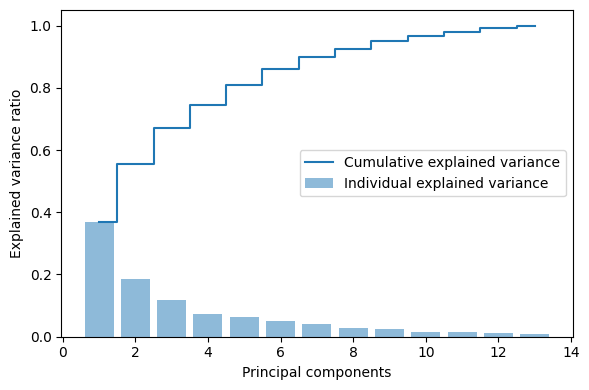

Number of components to explain 95% variance (train): 10


In [4]:
tot = sum(eigen_vals.real)
var_exp = [(i.real / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(6,4))
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Print how many components to reach 95%
n_95 = np.argmax(cum_var_exp >= 0.95) + 1
print(f'Number of components to explain 95% variance (train): {n_95}')


PCA using scikit-learn and classification

c:\Users\talif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\talif\AppData\Local\Temp\ipykernel_46592\2637679210.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


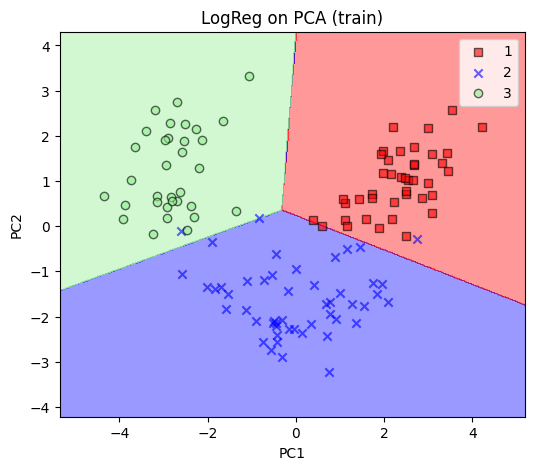

PCA (sklearn) - Test Accuracy: 0.926


In [5]:
pca = PCA(n_components=2)
X_train_pca_sk = pca.fit_transform(X_train_std)
X_test_pca_sk = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs', max_iter=2000)
lr.fit(X_train_pca_sk, y_train)

# Decision region helper
def plot_decision_regions(X, y, classifier, resolution=0.02, title=None, xlabel='PC1', ylabel='PC2'):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.6, c=np.array([cmap(idx)]),
                    edgecolor='black', marker=markers[idx], label=cl)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title: plt.title(title)
    plt.legend(loc='best')

plt.figure(figsize=(6,5))
plot_decision_regions(X_train_pca_sk, y_train, classifier=lr, title='LogReg on PCA (train)')
plt.show()

print('PCA (sklearn) - Test Accuracy: %.3f' % lr.score(X_test_pca_sk, y_test))


Part 2 — LDA
Scatter matrices & LDA from scratch

In [6]:
# mean vectors per class
mean_vecs = [np.mean(X_train_std[y_train == label], axis=0) for label in np.unique(y_train)]
d = X_train_std.shape[1]

# Within-class scatter matrix S_W
S_W = np.zeros((d, d))
for label, mv in zip(np.unique(y_train), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

# Between-class scatter matrix S_B
mean_overall = np.mean(X_train_std, axis=0).reshape(d, 1)
S_B = np.zeros((d, d))
for i, mv in enumerate(mean_vecs):
    n = X_train[y_train == i+1].shape[0]
    mv = mv.reshape(d, 1)
    S_B += n * (mv - mean_overall).dot((mv - mean_overall).T)

# Solve generalized eigenvalue problem inv(S_W) S_B
eigen_vals_lda, eigen_vecs_lda = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs_lda = sorted([(np.abs(eigen_vals_lda[i]), eigen_vecs_lda[:, i]) for i in range(len(eigen_vals_lda))],
                         key=lambda k: k[0], reverse=True)

# Projection matrix (top 2)
w_lda = np.hstack((eigen_pairs_lda[0][1][:, np.newaxis].real,
                   eigen_pairs_lda[1][1][:, np.newaxis].real))
X_train_lda = X_train_std.dot(w_lda)


LDA with scikit-learn and classification

c:\Users\talif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\talif\AppData\Local\Temp\ipykernel_46592\2637679210.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


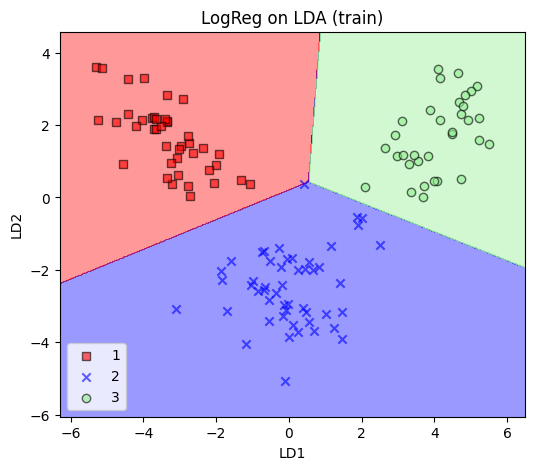

LDA (sklearn) - Test Accuracy: 1.000


In [7]:
lda = LDA(n_components=2)
X_train_lda_sk = lda.fit_transform(X_train_std, y_train)
X_test_lda_sk = lda.transform(X_test_std)

lr2 = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs', max_iter=2000)
lr2.fit(X_train_lda_sk, y_train)

plt.figure(figsize=(6,5))
plot_decision_regions(X_train_lda_sk, y_train, classifier=lr2, title='LogReg on LDA (train)', xlabel='LD1', ylabel='LD2')
plt.show()

print('LDA (sklearn) - Test Accuracy: %.3f' % lr2.score(X_test_lda_sk, y_test))


Part 3 — Kernel PCA (RBF kernel) — scratch implementation
RBF Kernel PCA function

In [8]:
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation returning top n_components projected coordinates
    """
    # Pairwise squared Euclidean distances
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)

    # Kernel matrix
    K = np.exp(-gamma * mat_sq_dists)

    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Eigenpairs
    eigvals, eigvecs = eigh(K_centered)
    # Collect top k (largest) eigenvectors
    alphas = np.column_stack([eigvecs[:, -i] for i in range(1, n_components + 1)])
    lambdas = [eigvals[-i] for i in range(1, n_components + 1)]

    return alphas, lambdas


Half-moons (nonlinear separation)

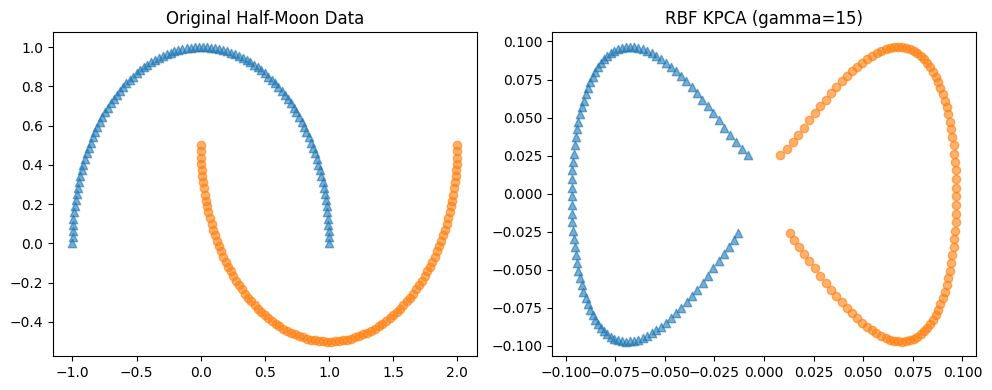

In [9]:
X_moons, y_moons = make_moons(n_samples=200, random_state=123)
alphas, lambdas = rbf_kernel_pca(X_moons, gamma=15, n_components=2)
X_kpca = alphas

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.scatter(X_moons[y_moons==0,0], X_moons[y_moons==0,1], marker='^', alpha=0.6)
ax1.scatter(X_moons[y_moons==1,0], X_moons[y_moons==1,1], marker='o', alpha=0.6)
ax1.set_title('Original Half-Moon Data')

ax2.scatter(X_kpca[y_moons==0,0], X_kpca[y_moons==0,1], marker='^', alpha=0.6)
ax2.scatter(X_kpca[y_moons==1,0], X_kpca[y_moons==1,1], marker='o', alpha=0.6)
ax2.set_title('RBF KPCA (gamma=15)')
plt.tight_layout()
plt.show()


Concentric circles

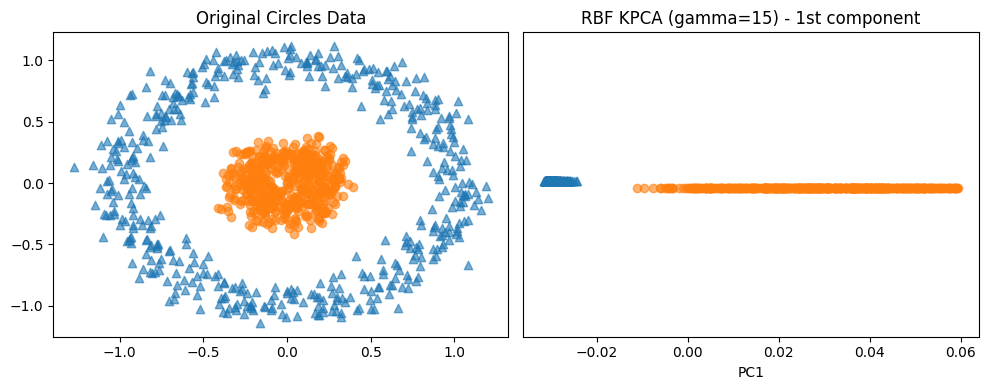

In [10]:
X_circ, y_circ = make_circles(n_samples=1000, factor=0.2, noise=0.1, random_state=123)
alphas_c, lambdas_c = rbf_kernel_pca(X_circ, gamma=15, n_components=2)
X_kpca_c = alphas_c

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.scatter(X_circ[y_circ==0,0], X_circ[y_circ==0,1], marker='^', alpha=0.6)
ax1.scatter(X_circ[y_circ==1,0], X_circ[y_circ==1,1], marker='o', alpha=0.6)
ax1.set_title('Original Circles Data')

# show first component vs jittered zero for visualization (1D separation)
ax2.scatter(X_kpca_c[y_circ==0,0], np.zeros((sum(y_circ==0),)) + 0.02, marker='^', alpha=0.6)
ax2.scatter(X_kpca_c[y_circ==1,0], np.zeros((sum(y_circ==1),)) - 0.02, marker='o', alpha=0.6)
ax2.set_ylim([-1,1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax2.set_title('RBF KPCA (gamma=15) - 1st component')
plt.tight_layout()
plt.show()


KPCA with scikit-learn

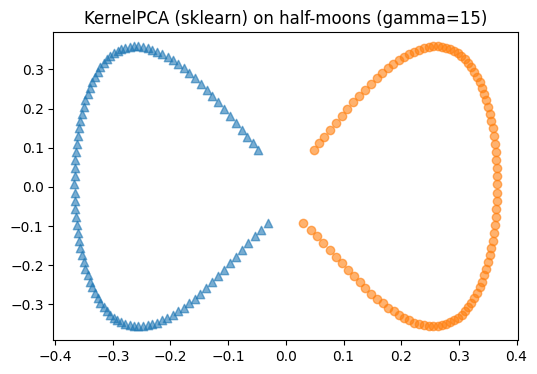

In [11]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15, fit_inverse_transform=False)
X_kpca_sk = kpca.fit_transform(X_moons)
plt.figure(figsize=(6,4))
plt.scatter(X_kpca_sk[y_moons==0,0], X_kpca_sk[y_moons==0,1], marker='^', alpha=0.6)
plt.scatter(X_kpca_sk[y_moons==1,0], X_kpca_sk[y_moons==1,1], marker='o', alpha=0.6)
plt.title('KernelPCA (sklearn) on half-moons (gamma=15)')
plt.show()


Measurements & Comparison: classifier accuracy & timing

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def time_and_score(clf, X_tr, y_tr, X_te, y_te):
    t0 = time.time()
    clf.fit(X_tr, y_tr)
    t1 = time.time()
    train_time = t1 - t0
    preds = clf.predict(X_te)
    acc = accuracy_score(y_te, preds)
    return train_time, acc

# Original features (standardized)
clf = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=2000)
t_orig, acc_orig = time_and_score(clf, X_train_std, y_train, X_test_std, y_test)

# PCA (2 comps)
clf_pca = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=2000)
t_pca, acc_pca = time_and_score(clf_pca, X_train_pca_sk, y_train, X_test_pca_sk, y_test)

# LDA (2 comps)
clf_lda = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=2000)
t_lda, acc_lda = time_and_score(clf_lda, X_train_lda_sk, y_train, X_test_lda_sk, y_test)

print(f'Original: time={t_orig:.4f}s, acc={acc_orig:.3f}')
print(f'PCA(2):   time={t_pca:.4f}s, acc={acc_pca:.3f}')
print(f'LDA(2):   time={t_lda:.4f}s, acc={acc_lda:.3f}')


Original: time=0.0463s, acc=1.000
PCA(2):   time=0.0202s, acc=0.926
LDA(2):   time=0.0197s, acc=1.000


c:\Users\talif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\talif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\talif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
